# Predicting next location

In this part of our project, we are mainly aiming to build a model to predict the location based on previous location history. Here we mainly focused on phone call data collected between Jan $1^{st}$ 2015 and Jan $7^{th}$ 2015. This is a time period with large number of tourists in Andorra from our EDA in Part 1.

The workflow of this notebook is as follows:
- Data cleaning
  - Cleaning data of the cell phone towers
  - Build dictionary to record each person's location and movement
- EDA on location changes of each person
- Build Machine Learning models to predict next location
- Results and conclusions
- Futuer directions

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Explanaiton of the CDR data
- Each row is a cell-phone making a phone call.
  - DS_CDNUMORIGEN: ciphered phone number
  - DT_CDDATAINICI and DT_CDDATAFI: start time and end time
  - NUM_DURADA: duration of phone call in second
  - ID_CELLA_INI and ID_CELLA_FI: start tower and end tower
  - ID_CDOPERADORORIGEN: code of cell phone carrier
- sub-Data
  - The original data are >6GB
  - Here we used the data from Jan 01-07, 2015.

- We will use ID_CELLA_INI (the start tower) as the approx. location. The towers are coded in number, and location of the tower can be extracted in the dataframe "tower".

- We will use ID_CDOPERADORORIGEN to extract where the person comes from (traveler vs local). The original region of the cell phone can be extracted from the dataframe "networks". 

In [3]:
tower=pd.read_csv("Andorra/towersArea.csv")
tower.head()

,place_id,latitude,longitude,Cluster,Code
0,180,42.475833,1.489722,CL0 - StJulia,1
1,181,42.475833,1.489722,CL0 - StJulia,1
2,1630,42.475833,1.489722,CL0 - StJulia,1
3,1631,42.475833,1.489722,CL0 - StJulia,1
4,10,42.460278,1.491111,CL0 - StJulia,1


In [4]:
network=pd.read_csv("Andorra/networks.csv")
network.head()

,region,code,carrier
0,Afghanistan,41240,Areba
1,Afghanistan,41250,Etislat
2,Afghanistan,41220,Roshan
3,Afghanistan,41201,Telephone Systems International (AWCC)
4,Albania,27601,AMC Mobile


In [ ]:
#Find out set of cell phone carrier codes that corresponding to a specific country
FranceCC=set(network[network.region=='France'].code)
SpainCC=set(network[network.region=='Spain'].code)
AndorraCC=set(network[network.region=='Andorra'].code)
OtherCC=set(network[(network.region!='Andorra') & (network.region!='France') & (network.region!='Spain')].code)

In [5]:
cdr01=pd.read_csv("Andorra/subsampled_CDR/2015_0101-08.csv")
cdr01.head()

,Unnamed: 0,DS_CDNUMORIGEN,DT_CDDATAINICI,DT_CDDATAFI,NUM_DURADA,ID_CELLA_INI,ID_CELLA_FI,ID_CDOPERADORORIGEN
0,0,9aff9f9d53ebd77d2cc0edc6eddb761b0c1d5ae7166ea8...,2015.01.02 00:03:50,2015.01.02 00:03:50,0,2021,2021,20801
1,1,9aff9f9d53ebd77d2cc0edc6eddb761b0c1d5ae7166ea8...,2015.01.02 00:54:39,2015.01.02 00:54:39,0,2021,2021,20801
2,2,dae9a69bc8e7fb7c7e3b601290c578baf5c8963839bcba...,2015.01.02 01:49:43,2015.01.02 01:49:43,0,101,101,21407
3,3,957ce1627bfd2a625fb6645c11392e6b22a239604fd9a5...,2015.01.02 00:30:35,2015.01.02 00:30:42,7,3531,3531,21407
4,4,161e38db04f53740a00aaf1734d5b07a19381567261ebf...,2015.01.02 00:01:58,2015.01.02 00:01:58,0,19091,19091,20801


## Data cleaning- tower
Notice that there are some place_id appears multiple times, suggesting they may provide ambigous information on location, so here we call them "bad_tower". In our following cleaning of data from CDR data, we will ignore singals collected from those "bad_tower"

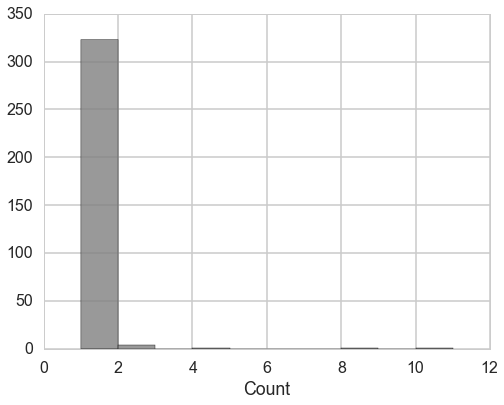

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.hist(tower.groupby('place_id').latitude.count(), color='grey', alpha=0.8)
ax.set_xlabel("Count")

In [6]:
bad_tower = tower.groupby('place_id').count()["latitude"]>1
bad_tower_id = bad_tower.index[bad_tower==True]

In [15]:
cluster

'CL0 - StJulia'

In [16]:
tower.loc[ind,'Code']

1

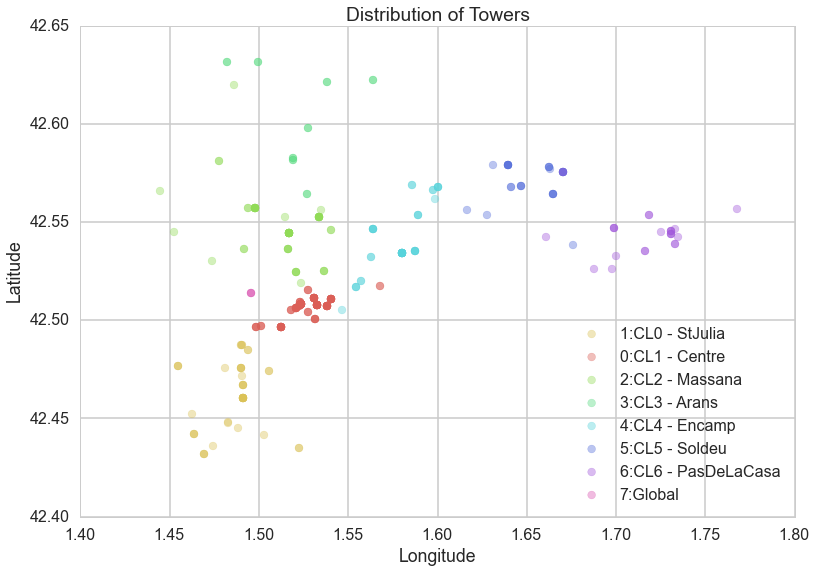

In [46]:
#Distribution of towers and cities
colors = sns.color_palette("hls", 8)
for cluster in tower.Cluster.unique():
    count = 0
    for ind in tower[tower.Cluster==cluster].index:
        count +=1
        if count==1:
            plt.scatter(tower.loc[ind,'longitude'], tower.loc[ind,'latitude'], color=colors[tower.loc[ind,'Code']], label=str(tower.loc[ind,'Code'])+':'+cluster, s=60, alpha=0.4)
        else:
            plt.scatter(tower.loc[ind,'longitude'], tower.loc[ind,'latitude'], color=colors[tower.loc[ind,'Code']], s=60, alpha=0.4)
plt.title("Distribution of Towers")
plt.legend(loc='lower right')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

There are multiple towers (different ids) corresponding to same location (latitude and longitude). We will use those clusters of tower (instead of the actual place_id or tower_id) for later location prediction.

In [19]:
len(tower)

354

In [20]:
len(tower.groupby(['latitude','longitude']).place_id.count())

100

In [21]:
#create tower cluster id
tgroups = tower.groupby(['latitude','longitude']).groups 
tower["towerCluster"] = [0] * len(tower)
ind = 0
for key in tgroups.keys():
    for row_id in tgroups[key]:
        tower.loc[row_id, 'towerCluster'] = ind
    ind += 1

In [22]:
tower.head()

,place_id,latitude,longitude,Cluster,Code,towerCluster
0,180,42.475833,1.489722,CL0 - StJulia,1,55
1,181,42.475833,1.489722,CL0 - StJulia,1,55
2,1630,42.475833,1.489722,CL0 - StJulia,1,55
3,1631,42.475833,1.489722,CL0 - StJulia,1,55
4,10,42.460278,1.491111,CL0 - StJulia,1,36


In [ ]:
#Save data to file
tower.to_csv("tower_cluster.csv", sep=',', encoding='utf-8')

In [23]:
# some CDR data are collected from towers not listed
sum(cdr01.ID_CELLA_INI<=tower.place_id.max())*1./len(cdr01)

0.99904475000000004

## Data cleaning- CDR

The original CDR file was sorted by the time of the phone call. In order to track one person's locations, 

In [ ]:
%%time
## This part was previouly run separately in another notebook. We saved the final output.
from datetime import datetime

FMT = '%Y.%m.%d %H:%M:%S'
months = {"Jan":'2015_0101-08.csv'} #"July":'2015_0701-08.csv'

French = {}
Spanish = {}

for month in months:
    print month
    file = "Andorra/subsampled_CDR/"+months[month]
    data = pd.read_csv(file)
    good_loc = (data.ID_CELLA_INI <= tower.place_id.max())
    mydata = data[good_loc.values]
    count = 0
    for index, row in mydata.iterrows(): 
        count += 1
        if ((row[7] in FranceCC) or (row[7] in SpainCC)) and (row[5] not in bad_tower_id):
            user = row[1]
            time_obj = datetime.strptime(row[2], FMT)
            if row[7] in FranceCC:
                if user in French.keys():
                    diff = int((time_obj-French[user]["time"]).total_seconds())/3600
                    if diff>0:
                        temp = tower[tower.place_id==row[5]][["latitude","longitude","Code","towerCluster"]].values
                        French[user]["hr"].append(French[user]["hr"][-1]+diff)
                        French[user]["loca"] = np.concatenate((French[user]["loca"],temp))
                        French[user]["time"] = time_obj
                else:
                    temp = tower[tower.place_id==row[5]][["latitude","longitude","Code","towerCluster"]].values
                    French[user]={"time":time_obj, "hr":[0], "loca":temp}
            if row[7] in SpainCC:
                if user in Spanish.keys():
                    diff = int((time_obj-Spanish[user]["time"]).total_seconds())/3600
                    if diff>0:
                        temp = tower[tower.place_id==row[5]][["latitude","longitude","Code","towerCluster"]].values
                        Spanish[user]["hr"].append(Spanish[user]["hr"][-1]+diff)
                        Spanish[user]["loca"] = np.concatenate((Spanish[user]["loca"],temp))
                        Spanish[user]["time"] = time_obj
                else:
                    temp = tower[tower.place_id==row[5]][["latitude","longitude","Code","towerCluster"]].values
                    Spanish[user]={"time":time_obj, "hr":[0], "loca":temp}
        if count%500000==0:
            print count

In [ ]:
# Saving data
import pickle
with open('tempdata/JanFrench.p', 'w') as outfile1:
    pickle.dump(French, outfile1)

with open('tempdata/JanSpanish.p', 'w') as outfile2:
    pickle.dump(Spanish, outfile2)

In [25]:
# import data
import pickle
with open('tempdata/JanFrench.p', 'r') as outfile1:
    French=pickle.load(outfile1)

with open('tempdata/JanSpanish.p', 'r') as outfile2:
    Spanish=pickle.load(outfile2)

In [26]:
len(French)

27437

In [27]:
len(Spanish)

89791

In [55]:
# One example from the data
key=French.keys()[1]
French[key]

{'hr': [0, 5, 18, 26, 27, 31, 40, 44, 53, 59, 60, 70, 72, 75, 81, 92, 116],
 'loca': array([[ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.63166667,   1.49944444,   3.        ,  46.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.53277778,   1.7       ,   6.        ,  65.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.        ],
        [ 42.50527778,   1.51777778,   0.        ,  39.   

## EDA on location changes of each person

[None]

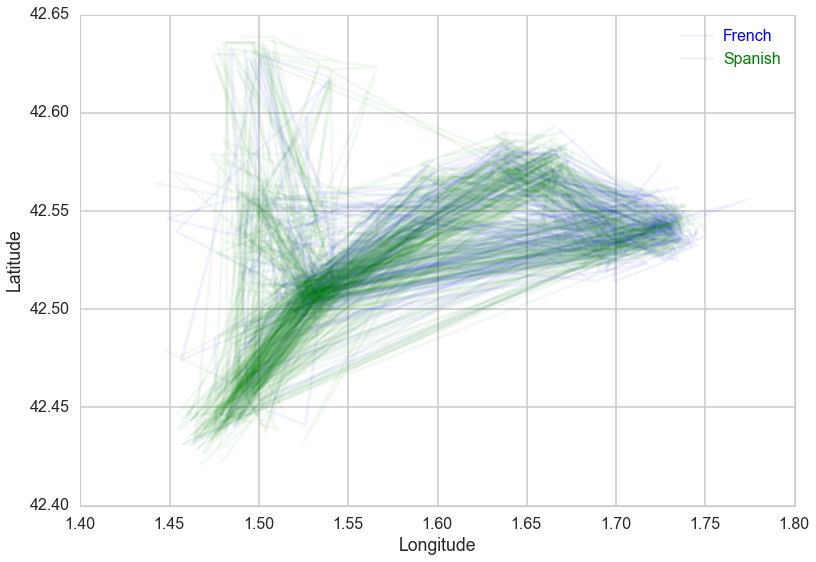

In [48]:
# plot of the trace of first 1000 French and first 1000 Spanish tourists
nF = 1000 

count = 0
for key in French.keys():
    count += 1
    j1, j2 = 0.005*np.random.randn(2)
    plt.plot(French[key]["loca"][:,1]+j1, French[key]["loca"][:,0]+j2, alpha=0.05, color='b')
    plt.axis([1.4, 1.8, 42.40, 42.65])
    if count > nF:
        break
        
nS = 1000 #int(len(Spanish)*per)
count = 0
for key in Spanish.keys():
    count += 1
    j1, j2 = 0.005*np.random.randn(2)
    plt.plot(Spanish[key]["loca"][:,1]+j1, Spanish[key]["loca"][:,0]+j2, alpha=0.05, color='g')
    plt.axis([1.4, 1.8, 42.40, 42.65])
    if count > nS:
        break

plt.xlabel("Longitude")
plt.ylabel("Latitude")
leg = plt.legend(("French", "Spanish"))
plt.setp(leg.get_texts()[0], color ='b')
plt.setp(leg.get_texts()[1], color ='g')

[None]

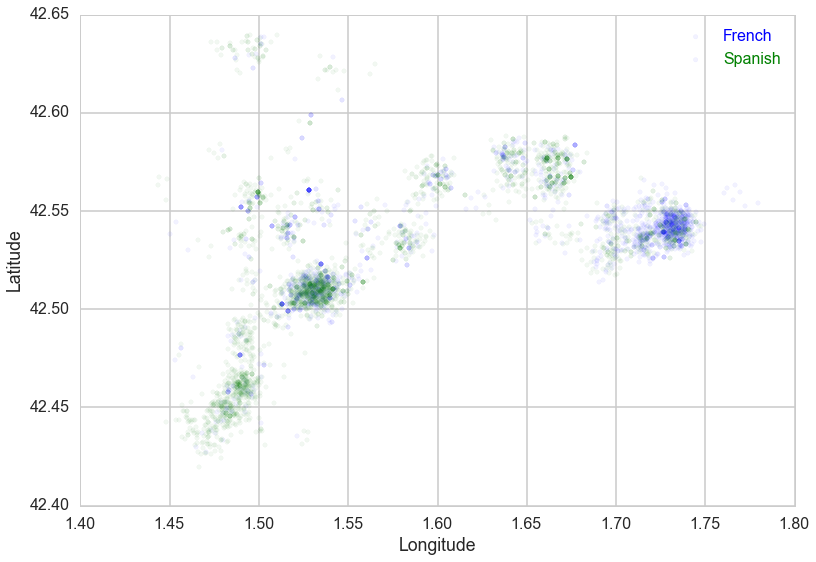

In [49]:
# scatter plot of 
nF = 1000 #int(len(French)*per)
count = 0
for key in French.keys():
    count += 1
    j1, j2 = 0.005*np.random.randn(2)
    plt.scatter(French[key]["loca"][:,1]+j1, French[key]["loca"][:,0]+j2, alpha=0.05, color='b')
    plt.axis([1.4, 1.8, 42.40, 42.65])
    if count > nF:
        break
        
nS = 1000 #int(len(Spanish)*per)
count = 0
for key in Spanish.keys():
    count += 1
    j1, j2 = 0.005*np.random.randn(2)
    plt.scatter(Spanish[key]["loca"][:,1]+j1, Spanish[key]["loca"][:,0]+j2, alpha=0.05, color='g')
    plt.axis([1.4, 1.8, 42.40, 42.65])
    if count > nS:
        break

plt.xlabel("Longitude")
plt.ylabel("Latitude")
leg = plt.legend(("French", "Spanish"))
plt.setp(leg.get_texts()[0], color ='b')
plt.setp(leg.get_texts()[1], color ='g')

Looking at the all location/moves, we can start to appreciate some differences between French and Spanish tourists. There are more blue (French) dots in 6:CL6 and more green (spanish) dots in 0:CL1-center. In the following 2 plots, we plotted the first 2 steps by French and by Spanish separately.

[None]

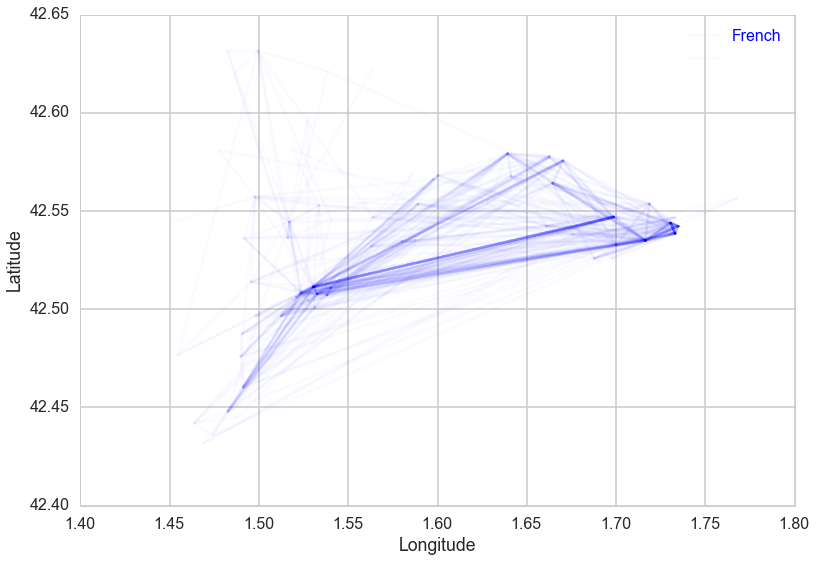

In [50]:
# first 2 steps: French
nF = 1000 #int(len(French)*per)
nS = 1000 #int(len(French)*per)

count = 0
for key in French.keys():
    j1, j2 = 0.005*np.random.randn(2)
    if French[key]["loca"].shape[0]>1:
        count += 1
        plt.plot(French[key]["loca"][range(2),1], French[key]["loca"][range(2),0], alpha=0.02, color='b')
        plt.axis([1.4, 1.8, 42.40, 42.65])
    if count > nF:
        break
plt.xlabel("Longitude")
plt.ylabel("Latitude")
leg = plt.legend(("French",''))
plt.setp(leg.get_texts()[0], color ='b')

[None]

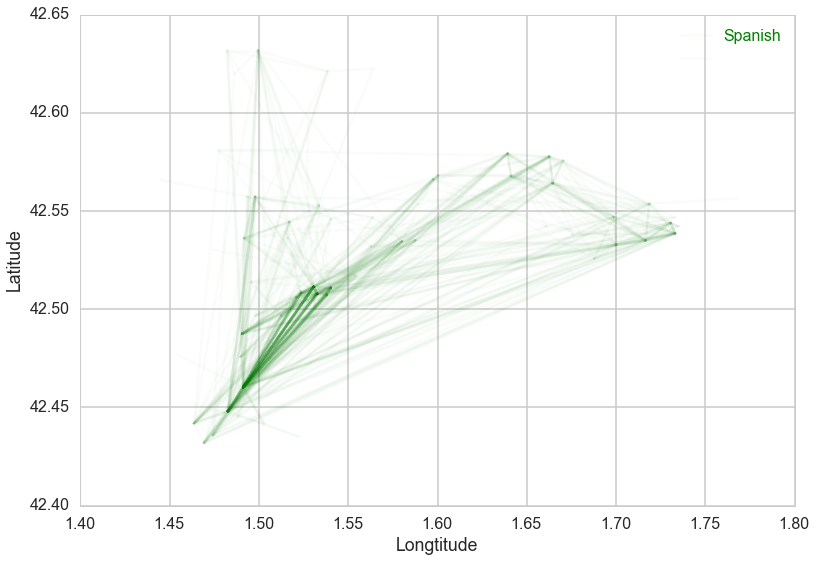

In [51]:
# First 2 steps: Spanish
count = 0
for key in Spanish.keys():
    j1, j2 = 0.005*np.random.randn(2)
    if Spanish[key]["loca"].shape[0]>1:
        count += 1
        plt.plot(Spanish[key]["loca"][range(2),1], Spanish[key]["loca"][range(2),0], alpha=0.02, color='g')
        plt.axis([1.4, 1.8, 42.40, 42.65])
    if count > nS:
        break
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
leg = plt.legend(("Spanish", ''))
plt.setp(leg.get_texts()[0], color ='g')

**Comparison of the first 2 locations between French and Spanish**



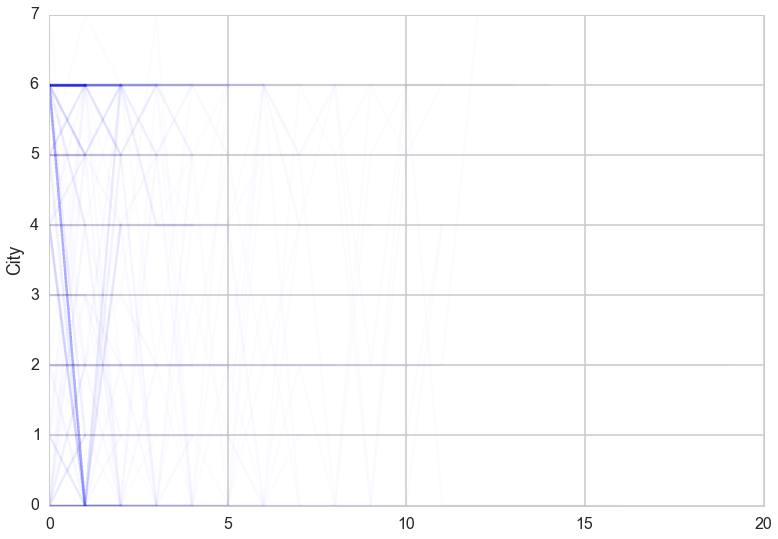

In [36]:
count = 0
for key in French.keys():
    j1, j2 = 0.005*np.random.randn(2)
    count += 1
    plt.plot(range(len(French[key]["loca"][:,2])), French[key]["loca"][:,2], alpha=0.01, color='b')
    plt.ylabel("City")
    if count > nF:
        break

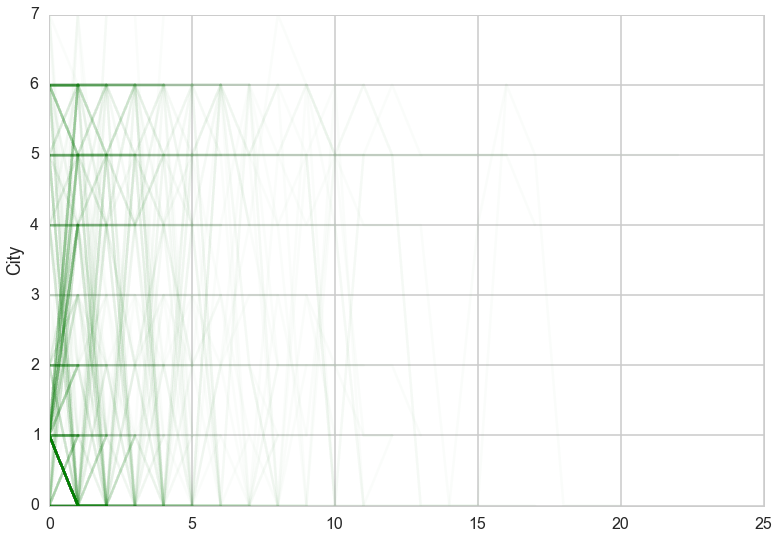

In [37]:
count = 0
for key in Spanish.keys():
    j1, j2 = 0.005*np.random.randn(2)
    count += 1
    plt.plot(range(len(Spanish[key]["loca"][:,2])), Spanish[key]["loca"][:,2], alpha=0.02, color='g')
    plt.ylabel("City")
    if count > nF:
        break

## Model selection for location prediction

Split data into train, cross-validation and test dataset

**French: -1**

test data: `Ftestkey`

train data: `Ftrkey`

cross-validation data: `Fcvkey`

**Spanish: -2**

test data: `Stestkey`

train data: `Strkey`

cross-validation data: `Scvkey`

In [ ]:
# Note: this part of the code was run in previously separated notebook
usersF = French.keys()
usersS = Spanish.keys()
from sklearn.cross_validation import train_test_split
itrainF, itestF = train_test_split(xrange(len(usersF)), train_size=0.7)
itrainS, itestS = train_test_split(xrange(len(usersS)), train_size=0.7)
itrF, icvF = train_test_split(xrange(len(itrainF)), train_size=0.7)
itrS, icvS = train_test_split(xrange(len(itrainS)), train_size=0.7)

In [ ]:
f_itrF = [itrainF[i] for i in itrF]
f_icvF = [itrainF[i] for i in icvF]
f_itrS = [itrainS[i] for i in itrS]
f_icvS = [itrainS[i] for i in icvS]

In [ ]:
Ftrkey = [usersF[i] for i in f_itrF]
Fcvkey = [usersF[i] for i in f_icvF]
Ftestkey = [usersF[i] for i in itestF]

Strkey = [usersS[i] for i in f_itrS]
Scvkey = [usersS[i] for i in f_icvS]
Stestkey = [usersS[i] for i in itestS]

In [ ]:
# save data for future use
import json
with open('tempdata/Ftrkey.json', 'w') as of1:
    Ftrkey=json.load(of1)
with open('tempdata/Fcvkey.json', 'w') as of2:
    Fcvkey=json.load(of2)
with open('tempdata/Ftestkey.json', 'w') as of3:
    Ftestkey=json.load(of3)

with open('tempdata/Strkey.json', 'w') as of4:
    Strkey=json.load(of4)
with open('tempdata/Scvkey.json', 'w') as of5:
    Scvkey=json.load(of5)
with open('tempdata/Stestkey.json', 'w') as of6:
    Stestkey=json.load(of6)

In [52]:
import json
with open('tempdata/Ftrkey.json', 'r') as of1:
    Ftrkey=json.load(of1)
with open('tempdata/Fcvkey.json', 'r') as of2:
    Fcvkey=json.load(of2)
with open('tempdata/Ftestkey.json', 'r') as of3:
    Ftestkey=json.load(of3)

with open('tempdata/Strkey.json', 'r') as of4:
    Strkey=json.load(of4)
with open('tempdata/Scvkey.json', 'r') as of5:
    Scvkey=json.load(of5)
with open('tempdata/Stestkey.json', 'r') as of6:
    Stestkey=json.load(of6)

## Multiclass classification

- In our data, we have multiple labels, so here comes the question: what data to use for prediction, and what data to predict. 
- The data we have are actually categorical data. They may not work as nicely as quantitative data.
- multiclass classification for city and tower
  - we have 7 city classes, and 100 tower classes (corresponding to 100 latitudes and longitudes)
  
- We decided to start with **city classification**, which only have 7 classes. At the same time, although it is less accurate in providing exact location, predicting city is still meaningful for services to provide recommendations.
- We decided to start with **Random Forest** algorithm, which intrinsicly deal with multiclass problems. We alse compared with other classification methods later on.

## Time series analysis

The main idea of time series analysis is that the current step depends on previous n steps. And here n is called the order. The classical time series analysis started from predicting $s(n)$ from $(s0,s1,...s[n-1])$. In our case,we also want to include 
- the prediciton of initial steps $s(0), s(1), \cdots$.
- nationality information in $X$ for prediction of $y$

Below is the `window` function that read a sequence and return the short pieces of the sequence as $X$

In [85]:
from itertools import islice

def window(seq, n=2, nation=-1):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (-1,-1,...-1), (-1,-1,...,s0), ...                       "
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    yield (nation,)+tuple([nation]*n)
    if n>1:
        for ind in range(n-1):
            yield (nation,)+tuple([nation]*(n-1-ind))+tuple(seq[0:ind+1])
            if len(seq)==ind+1:
                break
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield (nation,)+result    
    for elem in it:
        result = result[1:] + (elem,)
        yield (nation,)+result

Here is an example of the output of the `window` function.

In [87]:
seq=[0,1,2,3,4,5,6,7]
X=[]
for each in window(seq=seq, n=3, nation=-1):
    X.append(list(each))
X

[[-1, -1, -1, -1],
 [-1, -1, -1, 0],
 [-1, -1, 0, 1],
 [-1, 0, 1, 2],
 [-1, 1, 2, 3],
 [-1, 2, 3, 4],
 [-1, 3, 4, 5],
 [-1, 4, 5, 6],
 [-1, 5, 6, 7]]

In [90]:
def get_X(order, Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False, tower=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    if tower:
        ind = 3
        
    X = []
    header=["nation"]
    for past in range(order):
        header.append("past-"+str(order-past))
        
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            for each in window(seq=Fdict[key]['loca'][:,ind].tolist(), n=order, nation=-1):
                X.append(list(each))
            del X[-1]
    
    for key in Skey:
        if not Sdict[key]['loca'][:,3].tolist():
            pass
        else:
            for each in window(seq=Sdict[key]['loca'][:,ind].tolist(), n=order, nation=-2):
                X.append(list(each))
            del X[-1]
            
    X_df = pd.DataFrame(X, columns=header)
    
    return X_df

In [91]:
def get_y(Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    
    y = []
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            y = y+Fdict[key]['loca'][:,ind].tolist()
    
    for key in Skey:
        if not Sdict[key]['loca'][:,ind].tolist():
            pass
        else:
            y = y+Sdict[key]['loca'][:,ind].tolist()
            
    return y

### Predicting city using past city info using Random Forest

We will first run a cross-validation to determine the hyperparameters `order` and `n_estimators`. We will accuracy as our score function.

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [96]:
%%time
# cross-validation for orders and number of trees
accdict={}
orders = range(1,11)
trees = [1]+range(2,21,2)
for order in orders:
    Xtrain_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    Xcv_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    ytrain_ct = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    ycv_ct = get_y(Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    for tree in trees:
        print order, tree
        clfForest1_ct = RandomForestClassifier(n_estimators=tree)
        clfForest1_ct.fit(Xtrain_ct, ytrain_ct)
        ypredcv1_ct = clfForest1_ct.predict(Xcv_ct)
        suc = sum((np.array(ypredcv1_ct)-np.array(ycv_ct))==0)*1./len(ycv_ct)
        accdict.update({(order, tree): suc})

1 1
1 2
1 4
1 6
1 8
1 10
1 12
1 14
1 16
1 18
1 20
2 1
2 2
2 4
2 6
2 8
2 10
2 12
2 14
2 16
2 18
2 20
3 1
3 2
3 4
3 6
3 8
3 10
3 12
3 14
3 16
3 18
3 20
4 1
4 2
4 4
4 6
4 8
4 10
4 12
4 14
4 16
4 18
4 20
5 1
5 2
5 4
5 6
5 8
5 10
5 12
5 14
5 16
5 18
5 20
6 1
6 2
6 4
6 6
6 8
6 10
6 12
6 14
6 16
6 18
6 20
7 1
7 2
7 4
7 6
7 8
7 10
7 12
7 14
7 16
7 18
7 20
8 1
8 2
8 4
8 6
8 8
8 10
8 12
8 14
8 16
8 18
8 20
9 1
9 2
9 4
9 6
9 8
9 10
9 12
9 14
9 16
9 18
9 20
10 1
10 2
10 4
10 6
10 8
10 10
10 12
10 14
10 16
10 18
10 20
CPU times: user 6min 31s, sys: 30.7 s, total: 7min 2s
Wall time: 7min 4s


In [100]:
accdict

{(1, 1): 0.55902100931340692,
 (1, 2): 0.55902100931340692,
 (1, 4): 0.55898768764265838,
 (1, 6): 0.55902100931340692,
 (1, 8): 0.55902100931340692,
 (1, 10): 0.55902100931340692,
 (1, 12): 0.55902100931340692,
 (1, 14): 0.55902100931340692,
 (1, 16): 0.55902100931340692,
 (1, 18): 0.55902100931340692,
 (1, 20): 0.55902100931340692,
 (2, 1): 0.56336948734609549,
 (2, 2): 0.56376934739507834,
 (2, 4): 0.56368604321820692,
 (2, 6): 0.56375268655970412,
 (2, 8): 0.56355275653521264,
 (2, 10): 0.5641025641025641,
 (2, 12): 0.56361939987670984,
 (2, 14): 0.56360273904133551,
 (2, 16): 0.5638193299012012,
 (2, 18): 0.56385265157194986,
 (2, 20): 0.56393595574882127,
 (3, 1): 0.56395261658419549,
 (3, 2): 0.56478565835290984,
 (3, 4): 0.56508555338964694,
 (3, 6): 0.56550207427400412,
 (3, 8): 0.56570200429849549,
 (3, 10): 0.5658519518168641,
 (3, 12): 0.56583529098148977,
 (3, 14): 0.56536878759100984,
 (3, 16): 0.56606854267672979,
 (3, 18): 0.56583529098148977,
 (3, 20): 0.56551873510937

In [99]:
# best hyperparameters
maxtup=max(accdict, key=accdict.get)
maxtup

(3, 16)

Now we have decided for our random forest analysis:
$$order=3$$
$$n\_estimators=16$$
Let's look at the performance of the classifier on test data:

In [144]:
Ftrainkey = Ftrkey + Fcvkey
Strainkey = Strkey + Scvkey

order = maxtup[0]
tree = maxtup[1]

Xtrain_ct_fn = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
Xtest_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
ytrain_ct_fn = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
ytest_ct = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)

clfForest1_ct = RandomForestClassifier(n_estimators=tree)
clfForest1_ct.fit(Xtrain_ct_fn, ytrain_ct_fn)
ypredtest1_ct = clfForest1_ct.predict(Xtest_ct)
suc = sum((np.array(ypredtest1_ct)-np.array(ytest_ct))==0)*1.0/len(ytest_ct)

In [145]:
suc

0.57063728062503649

In [152]:
Xtest_ct.head()

,nation,past-3,past-2,past-1
0,-1,-1,-1,-1
1,-1,-1,-1,0
2,-1,-1,0,0
3,-1,-1,-1,-1
4,-1,-1,-1,-1


We also want to look at the distribution of prediction on each city. Here we adopted the code from HW3. Noted that since city here is categorical, the order of which does not really matter. Given this difference, the RMSE values may not really make sense. Nevertheless, the plot of predicted values against actual values can still tell us how well our classifier performs.

In [106]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [107]:
def compare_results(stars_actual, stars_predicted, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    lower = min(stars_actual)
    upper = max(stars_actual)
    
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.02, label="predicted for %s" % model)

    if not onsame:
        ax.plot([lower,upper],[lower,upper], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([lower-0.1,upper+0.1])
        ax.set_xlim([lower-0.1, upper+0.1])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for Randome Forest_city prediction 2.24051196911


(<matplotlib.axes._subplots.AxesSubplot at 0x123e190d0>, 2.2405119691129878)

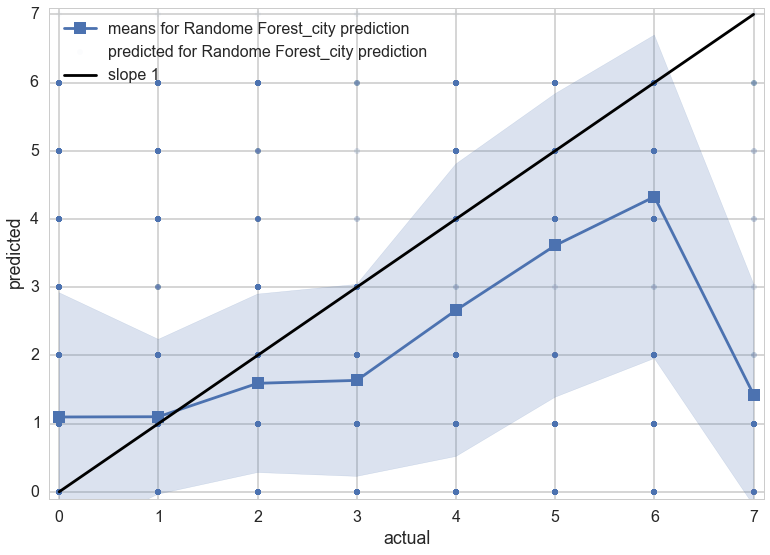

In [108]:
compare_results(ytest_ct, ypredtest1_ct, model="Randome Forest_city prediction", predicteds=True)

**Comment**

Given we have 7 cities, by purely guessing, the accuracy should be 0.14285714285714285. 

In [104]:
import pickle
with open('tempdata/ML_fn/RF_ct/accdict.p', 'w') as rfctof1:
    pickle.dump(accdict, rfctof1)
with open('tempdata/ML_fn/RF_ct/Xtrain_ct_fn.p', 'w') as rfctof2:
    pickle.dump(Xtrain_ct_fn, rfctof2)
with open('tempdata/ML_fn/RF_ct/Xtest_ct.p', 'w') as rfctof3:
    pickle.dump(Xtest_ct, rfctof3)
with open('tempdata/ML_fn/RF_ct/ytrain_ct_fn.p', 'w') as rfctof4:
    pickle.dump(ytrain_ct_fn, rfctof4)
with open('tempdata/ML_fn/RF_ct/ytest_ct.p', 'w') as rfctof5:
    pickle.dump(ytrain_ct_fn, rfctof5)
with open('tempdata/ML_fn/RF_ct/ypredtest1_ct.p', 'w') as rfctof7:
    pickle.dump(ypredtest1_ct, rcctof7) 

In [110]:
with open('tempdata/ML_fn/RF_ct/clfForest1_ct.p', 'w') as rfctof6:
    pickle.dump(clfForest1_ct, rfctof6)

### Using SVM to predict city

LinearSVC can be trained for one-vs-rest classification. So for each pair of hyperparameter, LinerSVC needs to train $n\_class$ classifiers. This methods may take quite some time.

In [109]:
from sklearn.svm import LinearSVC

In [111]:
%%time
# cross-validation for orders and number of trees
accdict_svm={}
orders = range(1,11)
Cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for order in orders:
    print order
    Xtrain_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    Xcv_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    ytrain_ct = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    ycv_ct = get_y(Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    for C in Cs:
        clfsvm_ct =LinearSVC(C=C)
        clfsvm_ct.fit(Xtrain_ct, ytrain_ct)
        ypredcv1_ct = clfsvm_ct.predict(Xcv_ct)
        suc = sum((np.array(ypredcv1_ct)-np.array(ycv_ct))==0)*1./len(ycv_ct)
        accdict_svm.update({(order, C): suc})

1
2
3
4
5
6
7
8
9
10
CPU times: user 2h 19min 1s, sys: 1min 14s, total: 2h 20min 15s
Wall time: 2h 21min 4s


In [112]:
accdict_svm

{(1, 0.001): 0.44947601672747872,
 (1, 0.01): 0.44947601672747872,
 (1, 0.1): 0.44947601672747872,
 (1, 1.0): 0.44947601672747872,
 (1, 10.0): 0.44439446193832161,
 (1, 100.0): 0.39546158844404461,
 (2, 0.001): 0.44947601672747872,
 (2, 0.01): 0.44947601672747872,
 (2, 0.1): 0.44947601672747872,
 (2, 1.0): 0.44947601672747872,
 (2, 10.0): 0.42153579580480166,
 (2, 100.0): 0.32112094100398192,
 (3, 0.001): 0.44912613918461874,
 (3, 0.01): 0.44944269505673012,
 (3, 0.1): 0.44934273004448444,
 (3, 1.0): 0.44934273004448444,
 (3, 10.0): 0.41203911964145884,
 (3, 100.0): 0.28323420136285632,
 (4, 0.001): 0.44845970576964728,
 (4, 0.01): 0.44262841338864728,
 (4, 0.1): 0.44261175255327301,
 (4, 1.0): 0.45109211775878444,
 (4, 10.0): 0.4224354809150131,
 (4, 100.0): 0.31927158827743624,
 (5, 0.001): 0.44472767864580731,
 (5, 0.01): 0.451941820362873,
 (5, 0.1): 0.45192515952749873,
 (5, 1.0): 0.45205844621049301,
 (5, 10.0): 0.35122707052531615,
 (5, 100.0): 0.18063677712800519,
 (6, 0.001): 

In [113]:
maxtup_svm=max(accdict_svm, key=accdict_svm.get)
maxtup_svm

(8, 1.0)

In [114]:
order = maxtup_svm[0]
C = maxtup_svm[1]

Xtrain_ct_fn_svm = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
Xtest_ct_svm = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
ytrain_ct_fn = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
ytest_ct = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)

clfsvm_ct = LinearSVC(C=C)
clfsvm_ct.fit(Xtrain_ct_fn_svm, ytrain_ct_fn)
ypredtest_svm_ct = clfsvm_ct.predict(Xtest_ct_svm)
suc = sum((np.array(ypredtest_svm_ct)-np.array(ytest_ct))==0)*1.0/len(ytest_ct)

In [115]:
suc

0.45507550580141098

** Comment on SVM**

Linear SVC actually have lower prediction accuracy than Random Forest. And The number of classifier is in the order of $O(n)$. For multiclass classification, non-linear SVM actually needs to train one-vs-one classifiers. The number of classifier is in the order of $O(n^2)$. Taken into the account of time, we think Random Forest is more practical method to use in predicting locations.

In [116]:
with open('tempdata/ML_fn/svm_ct/accdict_svm.p', 'w') as svmctof1:
    pickle.dump(accdict_svm, svmctof1)
with open('tempdata/ML_fn/svm_ct/Xtrain_ct_fn_svm.p', 'w') as svmctof2:
    pickle.dump(Xtrain_ct_fn_svm, svmctof2)
with open('tempdata/ML_fn/svm_ct/Xtest_ct_svm.p', 'w') as svmctof3:
    pickle.dump(Xtest_ct_svm, svmctof3)
with open('tempdata/ML_fn/svm_ct/ypredtest_svm_ct.p', 'w') as svmctof4:
    pickle.dump(ypredtest_svm_ct, svmctof4)
with open('tempdata/ML_fn/RF_ct/clfsvm_ct.p', 'w') as rfctof5:
    pickle.dump(clfsvm_ct, rfctof5)

### Predicting city from all data (city, tower, latitude, longitude) using Random Forest

Tower info provides finer location clusters than city. Latitude and longtitude can actually reflect the distance between 2 locations. Using all data may improve our prediction. Therefore here, want to all 4 types of data from the past n-order to predict the next city.

In [ ]:
def get_Xy_all(order, Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False, tower=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    if tower:
        ind = 3
        
    X = np.array([])
    y = []
    
    header = []
    lab = ['lat', 'lon', 'city', 'tower']
    for l in lab:
        header.append("nation")
        for past in range(order):
            header.append(l+"-"+"past-"+str(order-past))
            
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            y = y+Fdict[key]['loca'][:,ind].tolist()
            ftable = np.array([])
            for i in range(len(lab)):
                table = []
                for each in window(seq=Fdict[key]['loca'][:,i].tolist(), n=order, nation=-1):
                    table.append(list(each))
                del table[-1]
                table = np.array(table)
                ftable = np.hstack([ftable, table]) if ftable.size else table
            X = np.vstack([X, ftable]) if X.size else ftable
    
    for key in Skey:
        if not Sdict[key]['loca'][:,ind].tolist():
            pass
        else:
            y = y+Sdict[key]['loca'][:,ind].tolist()
            ftable = np.array([])
            for i in range(len(lab)):
                table = []
                for each in window(seq=Sdict[key]['loca'][:,i].tolist(), n=order, nation=-2):
                    table.append(list(each))
                del table[-1]
                table = np.array(table)
                ftable = np.hstack([ftable, table]) if ftable.size else table
            X = np.vstack([X, ftable]) if X.size else ftable
        
    X_df = pd.DataFrame(X, columns=header)
    
    return X_df, y

We will start with order=3, and tree=16 to see ho

In [ ]:
%%time
# cross-validation for orders and number of trees
accdict_all={}
orders = range(1,11)
trees = [1]+range(2,21,2)
for order in orders:
    print order
    Xtrain_all, ytrain_ct = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    Xcv_all, ycv_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    for tree in trees:
        clfForest_ct = RandomForestClassifier(n_estimators=tree)
        clfForest_ct.fit(Xtrain_all, ytrain_ct)
        ypredcv_ct = clfForest_ct.predict(Xcv_all)
        suc = sum((np.array(ypredcv_ct)-np.array(ycv_ct))==0)*1./len(ycv_ct)
        accdict_all.update({(order, tree): suc})

In [ ]:
maxtup_all=max(accdict_all, key=accdict_all.get)
maxtup_all

In [ ]:
order = maxtup[0]
tree = maxtup[1]

Xtrain_ct_fn_all, ytrain_ct_fn = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
Xtest_ct_all, ytest_ct = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)

clfForest_ct_all = RandomForestClassifier(n_estimators=tree)
clfForest_ct_all.fit(Xtrain_ct_fn_all, ytrain_ct_fn)
ypredtest_ct_all = clfForest_ct_all.predict(Xtest_ct_all)
suc = sum((np.array(ypredtest_ct_all)-np.array(ytest_ct))==0)*1.0/len(ytest_ct)

In [ ]:
suc

In [ ]:
with open('tempdata/ML_fn/RF_ct_alldata/accdict_all.p', 'w') as rfallctof1:
    pickle.dump(accdict_all, rfallctof1)
with open('tempdata/ML_fn/RF_ct_alldata/Xtrain_ct_fn_all.p', 'w') as rfallctof2:
    pickle.dump(Xtrain_ct_fn_all, rfallctof2)
with open('tempdata/ML_fn/RF_ct_alldata/Xtest_ct_all.p', 'w') as rfallctof3:
    pickle.dump(Xtest_ct_all, rfallctof3)
with open('tempdata/ML_fn/RF_ct_alldata/ypredtest_ct_all.p', 'w') as rfallctof4:
    pickle.dump(ypredtest_ct_all, rfallctof4)
with open('tempdata/ML_fn/RF_ct_alldata/clfForest_ct_all.p', 'w') as rfallctof5:
    pickle.dump(clfForest_ct_all, rfallctof5)

## Predicting tower id using Random Forest

In [ ]:
%%time
# cross-validation for orders and number of trees
accdict_tw={}
orders = range(1,11)
trees = [1]+range(2,21,2)
for order in orders:
    Xtrain_tw = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, tower=True)
    Xcv_tw = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, tower=True)
    ytrain_tw = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, tower=True)
    ycv_tw = get_y(Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, tower=True)
    for tree in trees:
        print order, tree
        clfForest1_tw = RandomForestClassifier(n_estimators=tree)
        clfForest1_tw.fit(Xtrain_tw, ytrain_tw)
        ypredcv1_tw = clfForest1_tw.predict(Xcv_tw)
        suc = sum((np.array(ypredcv1_tw)-np.array(ycv_tw))==0)*1./len(ycv_tw)
        accdict_tw.update({(order, tree): suc})

In [ ]:
maxtup_tw=max(accdict_tw, key=accdict_tw.get)
maxtup_tw

In [ ]:
order = maxtup_tw[0]
tree = maxtup_tw[1]

Xtrain_tw_fn = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, tower=True)
Xtest_tw = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, tower=True)
ytrain_tw_fn = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, tower=True)
ytest_tw = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, tower=True)

clfForest1_tw = RandomForestClassifier(n_estimators=tree)
clfForest1_tw.fit(Xtrain_tw_fn, ytrain_tw_fn)
ypredtest1_tw = clfForest1_tw.predict(Xtest_tw)
suc = sum((np.array(ypredtest1_tw)-np.array(ytest_tw))==0)*1.0/len(ytest_tw)

In [ ]:
suc

**Comment**

Low accuracy for tower prediction. However, with 100 towers, purely guessing will only yield 0.01 accuracy. So over 0.2 accuracy is also much higher than random guessing. But with accuracy of 0.2, it is difficult to build further analysis on top of it.

In [ ]:
with open('tempdata/ML_fn/RF_tw/accdict_tw.p', 'w') as rftwof1:
    pickle.dump(accdict_tw, rftwof1)
with open('tempdata/ML_fn/RF_tw/Xtrain_tw_fn.p', 'w') as rftwof2:
    pickle.dump(Xtrain_tw_fn, rftwof2)
with open('tempdata/ML_fn/RF_tw/Xtest_tw.p', 'w') as rftwof3:
    pickle.dump(Xtest_tw, rftwof3)
with open('tempdata/ML_fn/RF_tw/ytrain_tw_fn.p', 'w') as rftwof4:
    pickle.dump(ytrain_tw_fn, rftwof4)
with open('tempdata/ML_fn/RF_tw/ytest_tw.p', 'w') as rftwof5:
    pickle.dump(ytrain_tw_fn, rftwof5)
with open('tempdata/ML_fn/RF_tw/ypredtest1_tw.p', 'w') as rftwof7:
    pickle.dump(ypredtest1_tw, rftwof7)    
with open('tempdata/ML_fn/RF_tw/clfForest1_tw.p', 'w') as rftwof6:
    pickle.dump(clfForest1_tw, rftwof6)

### Map predicted tower id back to city

In [ ]:
for x in range(len(ypredtest1_tw)):
    ypredtest1_tw_ct.append(tower[tower.towerCluster==ypredtest1_tw[x]]["Code"].values[0])
suc = sum((np.array(ypredtest1_tw_ct)-np.array(ytest_ct))==0)*1.0/len(ytest_ct)

In [ ]:
suc

** comment **

In [ ]:
with open('tempdata/ML_fn/RF_tw/ypredtest1_tw_ct.p', 'w') as rftwof8:
    pickle.dump(ypredtest1_tw_ct, rftwof8)

## Predicting Latitude and Longitude



In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
accdict_ls_lat={}
accdict_ls_lon={}
orders = range(1,11)
Alphas = [0, 0.1, 0.5, 1.0, 5.0, 10.0]
for order in orders:
    print order
    Xtrain_all, ytrain_lat = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lat=True)
    ytrain_lon = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lat=True)
    Xcv_all, ycv_lat = get_X(order=order, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, lat=True)
    ycv_lon = get_y(Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lon=True)
    for alpha in Alphas:
        clfls_lat =Lasso(alpha=alpha)
        clfls_lat.fit(Xtrain_all, ytrain_lat)
        ypredls_lat = clfls_lat.predict(Xcv_all)
        accdict_ls_lat.update({(order, alpha): get_rmse(ycv_lat, ypredls_lat)})
        
        clfls_lon =Lasso(alpha=alpha)
        clfls_lon.fit(Xtrain_all, ytrain_lon)
        ypredls_lon = clfls_lat.predict(Xcv_all)
        accdict_ls_lon.update({(order, alpha): get_rmse(ycv_lon, ypredls_lon)})

In [ ]:
with open('tempdata/ML_fn/Lasso_latlon/accdict_ls_lat.p', 'w') as lsof1:
    pickle.dump(accdict_ls_lat, lsof1)
with open('tempdata/ML_fn/Lasso_latlon/accdict_ls_lon.p', 'w') as lsof2:
    pickle.dump(accdict_ls_lon, lsof2)

In [ ]:
mintup_lat=min(accdict_ls_lat, key=accdict_ls_lat.get)
mintup_lat

In [ ]:
mintup_lon=min(accdict_ls_lon, key=accdict_ls_lon.get)
mintup_lo

Latitude

In [ ]:
order = mintup_lat[0]
alpha = mintup_lat[1]

Xtrain_lat_fn, ytrain_lat_fn = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, lat=True)
Xtest_lat, ytest_lat = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, lat=True)

clfls_lat = Lasso(alpha=alpha)
clfls_lat.fit(Xtrain_lat_fn, ytrain_lat_fn)
ypredtest_lat = clfls_lat.predict(Xtest_lat)

In [ ]:
compare_results(ytest_lat, ypredtest_lat, model="Latitude_LASSO", predicteds=True);

Longitude

In [ ]:
order = mintup_lon[0]
alpha = mintup_lon[1]

Xtrain_lon_fn, ytrain_lon_fn = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, lon=True)
Xtest_lon, ytest_lon = get_Xy_all(order=order, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, lon=True)

clfls_lon = Lasso(alpha=alpha)
clfls_lon.fit(Xtrain_lon_fn, ytrain_lon_fn)
ypredtest_lon = clfls_lon.predict(Xtest_lon)

In [ ]:
compare_results(ytest_lon, ypredtest_lon, model="Longitude_LASSO", predicteds=True);

**Comment**

## Final comment on time series analysis on location prediction

After comparison of multiple models, we think the Random Forest approach here is the most reasonable one to apply. 

## Predicting using full past history

The previous method using sliding windows as X and the next locaiton as y has an assumption that the same rules between X and y at the beginning of the trip will be applied the same to the end of trip.

## end their trip or continue?

First, we want to predict whether a person will continue stay in Andorra or not based his/her location history in Andorra. This is potentially an interesting topic, because a company needs to decide whether they want to advertise some product to a certain tourist.

In [9]:
def get_X_history_end(aimstep, Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False, tower=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    if tower:
        ind = 3
        
    X = []
    
    header=["nation"]
    if aimstep>0:
        for past in range(aimstep):
            header.append("past-"+str(aimstep-past))
        
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            if len(Fdict[key]['loca'][:,ind].tolist())>=aimstep:
                X.append([-1]+Fdict[key]['loca'][range(aimstep),ind].tolist())
    
    for key in Skey:
        if not Sdict[key]['loca'][:,3].tolist():
            pass
        else:
            if len(Sdict[key]['loca'][:,ind].tolist())>=aimstep:
                X.append([-2]+Sdict[key]['loca'][range(aimstep),ind].tolist())
            
    X_df = pd.DataFrame(X, columns=header)
    
    return X_df

In [16]:
def get_y_history_end(aimstep, Fdict, Sdict, Fkey, Skey):
    
    y = []
    for key in Fkey:
        if not Fdict[key]['loca'][:,0].tolist():
            pass
        else:
            if len(Fdict[key]['loca'][:,0].tolist())==aimstep:
                y.append(0)
            elif len(Fdict[key]['loca'][:,0].tolist())>aimstep:
                y.append(1)
    
    for key in Skey:
        if not Sdict[key]['loca'][:,0].tolist():
            pass
        else:
            if len(Sdict[key]['loca'][:,0].tolist())==aimstep:
                y.append(0)
            if len(Sdict[key]['loca'][:,0].tolist())>aimstep:
                y.append(1)
            
    return y

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [53]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    y_pred = clf.predict(Xtest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, y_pred, test_accuracy

In [42]:
%%time

Ftrainkey = Ftrkey + Fcvkey
Strainkey = Strkey + Scvkey

Xtest_end = {}

ytest_end = {}
ytest_end_svmpred = {}
clfsvm_end = {}
accsvm = {}
ytest_end_logpred = {}
clflog_end = {}
acclog = {}

aimsteps = range(1,11)

for aimstep in aimsteps:
    print aimstep
    Xtrain_end = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
    ytrain_end = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey)
    
    Xtest_end[aimstep] = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
    ytest_end[aimstep] = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey)
    
    dftouse=pd.concat([Xtrain_end, Xtest_end[aimstep]], axis=0)
    lcols = dftouse.columns.values
    dftouse['RESP']=ytrain_end+ytest_end[aimstep]
    mask=np.array([1]*len(ytrain_end)+[0]*len(ytest_end[aimstep]))==1
    
    print "SVM"
    clfsvm_end[aimstep], ytest_end_svmpred[aimstep], accsvm[aimstep] = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'RESP',1, mask=mask)
    print "Logistic"
    clflog_end[aimstep], ytest_end_logpred[aimstep], acclog[aimstep] = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'RESP',1, mask=mask)

1
SVM
using mask
BEST {'C': 0.01} 0.594318855862 [mean: 0.57100, std: 0.00002, params: {'C': 0.001}, mean: 0.59432, std: 0.03118, params: {'C': 0.01}, mean: 0.59432, std: 0.03118, params: {'C': 0.1}, mean: 0.59432, std: 0.03118, params: {'C': 1.0}, mean: 0.59432, std: 0.03118, params: {'C': 10.0}, mean: 0.57298, std: 0.02134, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.59
Accuracy on test data:     0.59
[[ 3250 10631]
 [ 2540 16026]]
########################################################
Logistic
using mask
BEST {'C': 0.1} 0.594318855862 [mean: 0.57100, std: 0.00002, params: {'C': 0.001}, mean: 0.57870, std: 0.01538, params: {'C': 0.01}, mean: 0.59432, std: 0.03118, params: {'C': 0.1}, mean: 0.59432, std: 0.03118, params: {'C': 1.0}, mean: 0.59432, std: 0.03118, params: {'C': 10.0}, mean: 0.59432, std: 0.03118, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.59


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


SVM and Logistic regression with LASSO gives very similar results. Although the accuracy of each algorithm is about 0.7 for the late steps, a closer examination of the confusion matrix revealed that both algorithms basically predict every sample as positive response. In the original sample, ~70% of the sample will stay. To avoid the problem of imbalanced dataset, we implemented the following methods to make sure the training data contains same number of positive and 0 data.

In [70]:
## Balanced training data
Xtest_end = {}
ytest_end = {}

ytest_end_svmpred_b = {}
clfsvm_end_b = {}
accsvm_b = {}
ytest_end_logpred_b = {}
clflog_end_b = {}
acclog_b = {}

aimsteps = range(1,11)

for aimstep in aimsteps:
    print aimstep
    Xtrain_end = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
    ytrain_end = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey)
    
    Xtest_end[aimstep] = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
    ytest_end[aimstep] = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey)
    
    jtrain=np.arange(0, np.array(ytrain_end).shape[0])
    n_pos=len(jtrain[np.array(ytrain_end)==1])
    n_neg=len(jtrain[np.array(ytrain_end)==0])
    ipos = np.random.choice(jtrain[np.array(ytrain_end)==1], n_neg, replace=False)
    alli=np.concatenate((jtrain[np.array(ytrain_end)==0], ipos))
    Xtrain_new = Xtrain_end.iloc[alli]
    ytrain_new = [ytrain_end[i] for i in alli]
    
    dftouse=pd.concat([Xtrain_new, Xtest_end[aimstep]], axis=0)
    lcols = dftouse.columns.values
    dftouse['RESP']=ytrain_new+ytest_end[aimstep]
    mask=np.array([1]*len(ytrain_new)+[0]*len(ytest_end[aimstep]))==1
    
    print "SVM"
    clfsvm_end_b[aimstep], ytest_end_svmpred_b[aimstep], accsvm_b[aimstep] = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'RESP',1, mask=mask)
    print "Logistic"
    clflog_end_b[aimstep], ytest_end_logpred_b[aimstep], acclog_b[aimstep] = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'RESP',1, mask=mask)

1
SVM
using mask
BEST {'C': 0.001} 0.416041909912 [mean: 0.41604, std: 0.09258, params: {'C': 0.001}, mean: 0.40642, std: 0.10162, params: {'C': 0.01}, mean: 0.39008, std: 0.13283, params: {'C': 0.1}, mean: 0.37668, std: 0.15885, params: {'C': 1.0}, mean: 0.37668, std: 0.15885, params: {'C': 10.0}, mean: 0.38384, std: 0.16279, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.54
Accuracy on test data:     0.57
[[ 4432  9449]
 [ 4472 14094]]
########################################################
Logistic
using mask
BEST {'C': 0.01} 0.402153874516 [mean: 0.39951, std: 0.07891, params: {'C': 0.001}, mean: 0.40215, std: 0.10969, params: {'C': 0.01}, mean: 0.40215, std: 0.10969, params: {'C': 0.1}, mean: 0.40215, std: 0.10969, params: {'C': 1.0}, mean: 0.40215, std: 0.10969, params: {'C': 10.0}, mean: 0.40215, std: 0.10969, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.5

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


** Non linear?**

Balancing dataset worsened the prediction. We suspected that linear SVM and logistic regression (based on linear model) may not be able to capture the the non-linear relationship in the data. Therefore, we applied Random forest.

In [77]:
%%time
accrf_end={}
aimsteps = range(1,11)
trees = [1, 5, 10, 20]
for aimstep in aimsteps:
    Xtrain_end = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    Xcv_end = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    ytrain_end = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey)
    ycv_end = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey)
    
    for tree in trees:
        print aimstep, tree
        clfForest1_end = RandomForestClassifier(n_estimators=tree)
        clfForest1_end.fit(Xtrain_end, ytrain_end)
        ypredcv1_end = clfForest1_end.predict(Xcv_end)
        suc = sum((np.array(ypredcv1_end)-np.array(ycv_end))==0)*1./len(ycv_end)
        if aimstep in accrf_end.keys():
            accrf_end[aimstep].update({tree: suc})
        else:
            accrf_end.update({aimstep:{tree: suc}})

1 1
1 5
1 10
1 20
2 1
2 5
2 10
2 20
3 1
3 5
3 10
3 20
4 1
4 5
4 10
4 20
5 1
5 5
5 10
5 20
6 1
6 5
6 10
6 20
7 1
7 5
7 10
7 20
8 1
8 5
8 10
8 20
9 1
9 5
9 10
9 20
10 1
10 5
10 10
10 20
CPU times: user 11.1 s, sys: 156 ms, total: 11.3 s
Wall time: 11.4 s


In [79]:
ytest_end = {}
ytest_end_rfpred = {}
clfForest_end = {}
suc_end = {}
for aimstep in maxtup_end.keys():
    print aimstep
    Xtrain_end_fn = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
    ytrain_end_fn = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey)
    
    Xtest_end = get_X_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
    ytest_end[aimstep] = get_y_history_end(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey)
    
    clfForest_end[aimstep] = RandomForestClassifier(n_estimators=maxtup_end[aimstep])
    clfForest_end[aimstep].fit(Xtrain_end_fn, ytrain_end_fn)
    ytest_end_rfpred[aimstep] = clfForest_end[aimstep].predict(Xtest_end)
    print confusion_matrix(ytest_end[aimstep], ytest_end_rfpred[aimstep])
    suc_end[aimstep] = sum((np.array(ytest_end_rfpred[aimstep])-np.array(ytest_end[aimstep]))==0)*1.0/len(ytest_end[aimstep])

1
[[ 2776 11105]
 [ 1316 17250]]
2
[[ 1471  5962]
 [  650 10483]]
3
[[ 795 3141]
 [ 410 6787]]
4
[[ 379 1956]
 [ 403 4459]]
5
[[ 264 1219]
 [ 331 3048]]
6
[[ 219  820]
 [ 286 2054]]
7
[[ 153  527]
 [ 208 1452]]
8
[[  84  400]
 [ 134 1042]]
9
[[ 81 271]
 [102 722]]
10
[[ 58 177]
 [ 97 492]]


In [78]:
maxtup_end={}
for key in accrf_end.keys():
    maxtup_end[key]=max(accrf_end[key], key=accrf_end[key].get)
maxtup_end

{1: 5, 2: 1, 3: 10, 4: 20, 5: 10, 6: 20, 7: 20, 8: 20, 9: 20, 10: 10}

In [80]:
suc_end

{1: 0.61719111165901319,
 2: 0.64386512980717436,
 3: 0.68103835444174976,
 4: 0.67222453800194526,
 5: 0.68120115178938712,
 6: 0.6726842261023972,
 7: 0.6858974358974359,
 8: 0.67831325301204815,
 9: 0.68282312925170063,
 10: 0.66747572815533984}

From the confusion matrix above, randomforest methods 

## If we predict the tourist will stay in Andorra, where will he/she go next?


In [118]:
def get_X_history(aimstep, Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False, tower=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    if tower:
        ind = 3
        
    X = []
    
    header=["nation"]
    if aimstep>0:
        for past in range(aimstep):
            header.append("past-"+str(aimstep-past))
        
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            if len(Fdict[key]['loca'][:,ind].tolist())>aimstep:
                X.append([-1]+Fdict[key]['loca'][range(aimstep),ind].tolist())
    
    for key in Skey:
        if not Sdict[key]['loca'][:,3].tolist():
            pass
        else:
            if len(Sdict[key]['loca'][:,ind].tolist())>aimstep:
                X.append([-2]+Sdict[key]['loca'][range(aimstep),ind].tolist())
            
    X_df = pd.DataFrame(X, columns=header)
    
    return X_df

In [119]:
def get_y_history(aimstep, Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False, tower=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    if tower:
        ind = 3
    
    y = []
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            if len(Fdict[key]['loca'][:,ind].tolist())>aimstep:
                y.append(Fdict[key]['loca'][aimstep,ind])
    
    for key in Skey:
        if not Sdict[key]['loca'][:,ind].tolist():
            pass
        else:
            if len(Sdict[key]['loca'][:,ind].tolist())>aimstep:
                y.append(Sdict[key]['loca'][aimstep,ind])
            
    return y

We will start with predicting the first 10 steps.

In [127]:
%%time
# cross-validation for orders and number of trees
accdict_full={}
aimsteps = range(11)
trees = [1]+range(2,21,2)
for aimstep in aimsteps:
    print aimstep
    Xtrain_ct = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    Xcv_ct = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)
    ytrain_ct = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, city=True)
    ycv_ct = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, city=True)

    for tree in trees:
        clfForest1_ct = RandomForestClassifier(n_estimators=tree)
        clfForest1_ct.fit(Xtrain_ct, ytrain_ct)
        ypredcv1_ct = clfForest1_ct.predict(Xcv_ct)
        suc = sum((np.array(ypredcv1_ct)-np.array(ycv_ct))==0)*1./len(ycv_ct)
        if aimstep in accdict_full.keys():
            accdict_full[aimstep].update({tree: suc})
        else:
            accdict_full.update({aimstep:{tree: suc}})

0
1
2
3
4
5
6
7
8
9
10
CPU times: user 14.8 s, sys: 407 ms, total: 15.2 s
Wall time: 15.2 s


In [128]:
accdict_full

{0: {1: 0.49384723565087457,
  2: 0.49384723565087457,
  4: 0.49384723565087457,
  6: 0.49384723565087457,
  8: 0.49384723565087457,
  10: 0.49384723565087457,
  12: 0.49384723565087457,
  14: 0.49384723565087457,
  16: 0.49384723565087457,
  18: 0.49384723565087457,
  20: 0.49384723565087457},
 1: {1: 0.566991333691234,
  2: 0.56706802668916323,
  4: 0.56706802668916323,
  6: 0.56706802668916323,
  8: 0.56706802668916323,
  10: 0.56706802668916323,
  12: 0.566991333691234,
  14: 0.56706802668916323,
  16: 0.56706802668916323,
  18: 0.56706802668916323,
  20: 0.56706802668916323},
 2: {1: 0.61594855305466234,
  2: 0.61839228295819937,
  4: 0.6168488745980707,
  6: 0.61877813504823154,
  8: 0.61723472668810286,
  10: 0.61916398713826371,
  12: 0.61903536977491957,
  14: 0.61864951768488741,
  16: 0.61839228295819937,
  18: 0.61749196141479101,
  20: 0.61864951768488741},
 3: {1: 0.61069455406471984,
  2: 0.6124704025256511,
  4: 0.61404893449092346,
  6: 0.61444356748224149,
  8: 0.6128

In [129]:
# best hyperparameters
maxtup_full={}
for key in accdict_full.keys():
    maxtup_full[key]=max(accdict_full[key], key=accdict_full[key].get)

In [130]:
maxtup_full

{0: 1, 1: 2, 2: 10, 3: 10, 4: 20, 5: 12, 6: 18, 7: 20, 8: 20, 9: 20, 10: 12}

In [146]:
Ftrainkey = Ftrkey + Fcvkey
Strainkey = Strkey + Scvkey

ytest_full = {}
ytest_full_pred = {}
clfForest_full = {}
suc_full = {}
for aimstep in maxtup_full.keys():
    Xtrain_ct_fn_full = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
    ytrain_ct_fn_full = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, city=True)
    
    Xtest_ct_full = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
    ytest_full[aimstep] = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
    
    clfForest_full[aimstep] = RandomForestClassifier(n_estimators=maxtup_full[aimstep])
    clfForest_full[aimstep].fit(Xtrain_ct_fn_full, ytrain_ct_fn_full)
    ytest_full_pred[aimstep] = clfForest_full[aimstep].predict(Xtest_ct_full)
    suc_full[aimstep] = sum((np.array(ytest_full_pred[aimstep])-np.array(ytest_full[aimstep]))==0)*1.0/len(ytest_full[aimstep])

In [147]:
import pickle
with open('tempdata/ML_fn/RF_fullhist/accdict_full.p', 'w') as rffullof1:
    pickle.dump(accdict_full, rffullof1)
with open('tempdata/ML_fn/RF_fullhist/ytest_full.p', 'w') as rffullof2:
    pickle.dump(ytest_full, rffullof2)
with open('tempdata/ML_fn/RF_fullhist/ytest_full_pred.p', 'w') as rffullof3:
    pickle.dump(ytest_full_pred, rffullof3)
with open('tempdata/ML_fn/RF_fullhist/clfForest_full.p', 'w') as rffullof4:
    pickle.dump(clfForest_full, rffullof4)
with open('tempdata/ML_fn/RF_fullhist/suc_full.p', 'w') as rffullof5:
    pickle.dump(suc_full, rffullof5)

In [148]:
suc_full

{0: 0.50035442413782472,
 1: 0.56425724442529357,
 2: 0.61762328213419559,
 3: 0.62734472696957067,
 4: 0.61867544220485393,
 5: 0.61112755253033446,
 6: 0.6299145299145299,
 7: 0.66204819277108429,
 8: 0.6462585034013606,
 9: 0.68082524271844658,
 10: 0.6417657045840407}

## comparing result

RMSE for City_RandomForest_step_0 2.41661251055
RMSE for City_RandomForest_step_1 2.34523084659
RMSE for City_RandomForest_step_2 2.00509097849
RMSE for City_RandomForest_step_3 2.04102021366


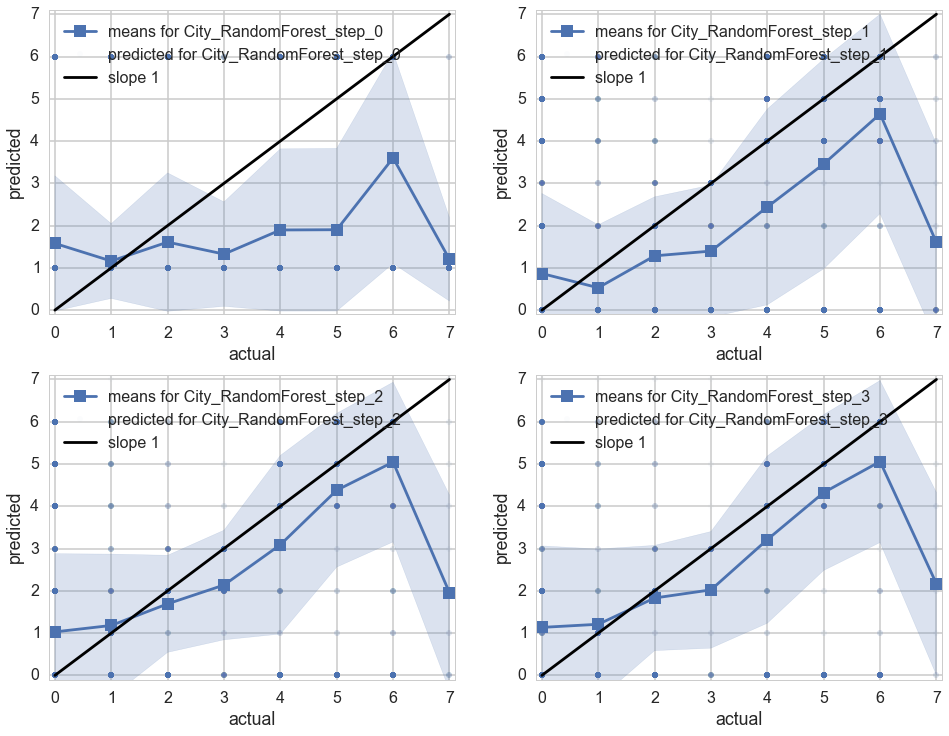

In [135]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=2, ncols=2, tight_layout=False)
for ax, aimstep in zip(axes.ravel(), range(4)):
    compare_results(ytest_full[aimstep], ytest_full_pred[aimstep], model="City_RandomForest_step_"+str(aimstep), predicteds=True, axis=ax);

**Comment on predicting next location using full history**


### Is full history better than 3-order prediction? 

In [154]:
def get_X_aimorder(aimstep, order, Fdict, Sdict, Fkey, Skey, lat=False, lon=False, city=False, tower=False):
    if lat:
        ind = 0
    if lon:
        ind = 1
    if city:
        ind = 2
    if tower:
        ind = 3
        
    X = []
    
    header=["nation"]
    for past in range(order):
        header.append("past-"+str(order-past))
        
    for key in Fkey:
        if not Fdict[key]['loca'][:,ind].tolist():
            pass
        else:
            if len(Fdict[key]['loca'][:,ind].tolist())>aimstep:
                if aimstep < order:
                    X.append([-1]+[-1]*(order-aimstep)+Fdict[key]['loca'][range(aimstep),ind].tolist())
                else:
                    X.append([-1]+Fdict[key]['loca'][range(aimstep-order,aimstep),ind].tolist())
    
    for key in Skey:
        if not Sdict[key]['loca'][:,3].tolist():
            pass
        else:
            if len(Sdict[key]['loca'][:,ind].tolist())>aimstep:
                if aimstep < order:
                    X.append([-1]+[-1]*(order-aimstep)+Sdict[key]['loca'][range(aimstep),ind].tolist())
                else:
                    X.append([-1]+Sdict[key]['loca'][range(aimstep-order,aimstep),ind].tolist())
            
    X_df = pd.DataFrame(X, columns=header)
    
    return X_df

In [155]:
ypred_cf1_3 = {}
suc_cf1_3 = {}
for aimstep in maxtup_full.keys():
    Xtest_ct_3 = get_X_aimorder(aimstep, order=3, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, city=True)
    ypred_cf1_3[aimstep]=clfForest1_ct.predict(Xtest_ct_3)
    suc_cf1_3[aimstep] = sum((np.array(ypred_cf1_3[aimstep])-np.array(ytest_full[aimstep]))==0)*1.0/len(ytest_full[aimstep])

In [156]:
suc_cf1_3

{0: 0.22140721792461554,
 1: 0.5618334590110956,
 2: 0.59166442109045181,
 3: 0.61900791996665272,
 4: 0.62525709584533118,
 5: 0.63657886948801423,
 6: 0.65641025641025641,
 7: 0.6837349397590361,
 8: 0.67091836734693877,
 9: 0.67839805825242716,
 10: 0.68590831918505946}

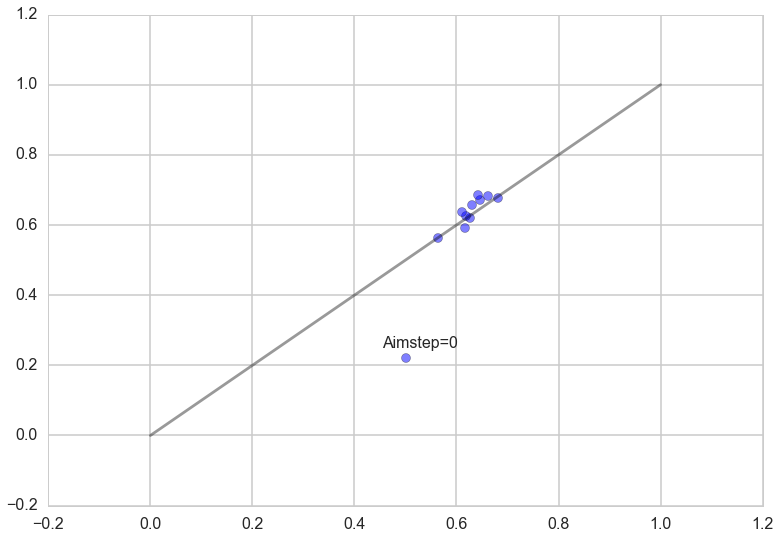

In [169]:
for aimstep in maxtup_full.keys():   
    plt.scatter(suc_full[aimstep], suc_cf1_3[aimstep], alpha=0.5, s=80)
    if aimstep==0:
        plt.annotate("Aimstep=0", xy = (suc_full[0]+0.1, suc_cf1_3[0]+0.02), xytext = (0.2, 0.2),
        textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=16)
plt.plot([0,1],[0,1], alpha=0.4, color='k')

** Comment **

Except for predicting the first step, Random forest based time series analysis with order=3 actually have quite similar performance in terms of accuracy compared to prediction using full history. 

### Predicting Latitude and Longitude using Lasso

Here we will combine both latitude and longitude as X for prediction

In [79]:
pd.concat([Xtrain_tower, Xtrain_ct], axis=1).head()

,nation,past-10,past-9,past-8,past-7,past-6,past-5,past-4,past-3,past-2,past-1,nation,past-10,past-9,past-8,past-7,past-6,past-5,past-4,past-3,past-2,past-1
0,-1,12,28,28,28,28,28,56,2,2,28,-1,6,0,0,0,0,0,5,5,5,0
1,-1,52,52,52,52,38,52,52,52,52,52,-1,2,2,2,2,5,2,2,2,2,2
2,-1,0,0,59,0,0,0,0,0,92,0,-1,6,6,5,6,6,6,6,6,6,6
3,-1,38,40,52,46,52,70,52,52,52,52,-1,5,3,2,3,2,4,2,2,2,2
4,-1,92,92,38,2,92,92,92,92,92,91,-1,6,6,5,5,6,6,6,6,6,0


In [77]:
from sklearn.linear_model import Lasso

In [83]:
%%time

accdict_lat={}
accdict_lon={}
aimsteps = range(11)
alphas=[0.1, 0.5, 1, 5]

for aimstep in aimsteps:
    Xtrain_lat = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lat=True)
    Xcv_lat = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, lat=True)
    Xtrain_lon = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lon=True)
    Xcv_lon = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, lon=True)
    
    Xtrain_latlon = pd.concat([Xtrain_lat, Xtrain_lon], axis=1)
    Xcv_latlon = pd.concat([Xcv_lat, Xcv_lon], axis=1)
    
    ytrain_lat = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lat=True)
    ycv_lat = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, lat=True)
    ytrain_lon = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrkey, Skey=Strkey, lon=True)
    ycv_lon = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Fcvkey, Skey=Scvkey, lon=True)
    
    for alpha in alphas:
        print aimstep, alpha
        clfLasso_lat = Lasso(alpha=alpha)
        clfLasso_lat.fit(Xtrain_latlon, ytrain_lat)
        ypredcv_lat = clfLasso_lat.predict(Xcv_latlon)
        rmse_lat = get_rmse(ycv_lat, ypredcv_lat)
        if aimstep in accdict_lat.keys():
            accdict_lat[aimstep].update({alpha: rmse_lat})
        else:
            accdict_lat.update({aimstep:{alpha: rmse_lat}})
        
        clfLasso_lon = Lasso(alpha=alpha)
        clfLasso_lon.fit(Xtrain_latlon, ytrain_lon)
        ypredcv_lon = clfLasso_lon.predict(Xcv_latlon)
        rmse_lon = get_rmse(ycv_lon, ypredcv_lon)
        if aimstep in accdict_lon.keys():
            accdict_lon[aimstep].update({alpha: rmse_lon})
        else:
            accdict_lon.update({aimstep:{alpha: rmse_lon}})

0 0.1
0 0.5
0 1
0 5
1 0.1
1 0.5
1 1
1 5
2 0.1
2 0.5
2 1
2 5
3 0.1
3 0.5
3 1
3 5
4 0.1
4 0.5
4 1
4 5
5 0.1
5 0.5
5 1
5 5
6 0.1
6 0.5
6 1
6 5
7 0.1
7 0.5
7 1
7 5
8 0.1
8 0.5
8 1
8 5
9 0.1
9 0.5
9 1
9 5
10 0.1
10 0.5
10 1
10 5
CPU times: user 17.4 s, sys: 262 ms, total: 17.6 s
Wall time: 17.7 s


In [84]:
accdict_lon

{0: {0.1: 0.094980789281467998,
  0.5: 0.094980789281467998,
  1: 0.094980789281467998,
  5: 0.094980789281467998},
 1: {0.1: 0.081778427019328789,
  0.5: 0.081778427019328789,
  1: 0.081778427019328789,
  5: 0.081778427019328789},
 2: {0.1: 0.081989292709405484,
  0.5: 0.081989292709405484,
  1: 0.081989292709405484,
  5: 0.081989292709405484},
 3: {0.1: 0.082497149812721826,
  0.5: 0.082497149812721826,
  1: 0.082497149812721826,
  5: 0.082497149812721826},
 4: {0.1: 0.082735376884663342,
  0.5: 0.082735376884663342,
  1: 0.082735376884663342,
  5: 0.082735376884663342},
 5: {0.1: 0.081616003082042671,
  0.5: 0.081616003082042671,
  1: 0.081616003082042671,
  5: 0.081616003082042671},
 6: {0.1: 0.082231531166759561,
  0.5: 0.082231531166759561,
  1: 0.082231531166759561,
  5: 0.082231531166759561},
 7: {0.1: 0.080931392891647691,
  0.5: 0.080931392891647691,
  1: 0.080931392891647691,
  5: 0.080931392891647691},
 8: {0.1: 0.0798181586201962,
  0.5: 0.0798181586201962,
  1: 0.07981815

In [85]:
with open('tempdata/ML_4/accdict_lat.p', 'w') as of16:
    pickle.dump(accdict_lat, of16)
with open('tempdata/ML_4/accdict_lon.p', 'w') as of17:
    pickle.dump(accdict_lon, of17)

In [86]:
maxtup_lat={}
for key in accdict_lat.keys():
    maxtup_lat[key]=max(accdict_lat[key], key=accdict_lat[key].get)

maxtup_lon={}
for key in accdict_lon.keys():
    maxtup_lon[key]=max(accdict_lon[key], key=accdict_lon[key].get)

In [87]:
maxtup_lat

{0: 0.5,
 1: 0.5,
 2: 0.5,
 3: 0.5,
 4: 0.5,
 5: 0.5,
 6: 0.5,
 7: 0.5,
 8: 0.5,
 9: 0.5,
 10: 0.5}

In [88]:
maxtup_lon

{0: 0.5,
 1: 0.5,
 2: 0.5,
 3: 0.5,
 4: 0.5,
 5: 0.5,
 6: 0.5,
 7: 0.5,
 8: 0.5,
 9: 0.5,
 10: 0.5}

In [89]:
%%time
ytest_lat = {}
ytest_lat_pred = {}
clfLasso_lat = {}
rmse_lat = {}

ytest_lon = {}
ytest_lon_pred = {}
clfLasso_lon = {}
rmse_lon = {}
for aimstep in maxtup.keys():
    Xtrain_lat_fn = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, lat=True)
    Xtrain_lon_fn = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, lon=True)
    Xtrain_fn = pd.concat([Xtrain_lat_fn, Xtrain_lon_fn], axis=1)
    
    ytrain_lat_fn = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, lat=True)
    ytrain_lon_fn = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftrainkey, Skey=Strainkey, lon=True)
    
    
    Xtest_lat = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, lat=True)
    Xtest_lon = get_X_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, lon=True)
    Xtest_fn = pd.concat([Xtest_lat, Xtest_lon], axis=1)
    
    ytest_lat[aimstep] = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, lat=True)
    ytest_lon[aimstep] = get_y_history(aimstep=aimstep, Fdict=French, Sdict=Spanish, Fkey=Ftestkey, Skey=Stestkey, lon=True)
    
    clfLasso_lat[aimstep] = Lasso(alpha=maxtup_lat[aimstep])
    clfLasso_lat[aimstep].fit(Xtrain_fn, ytrain_lat_fn)
    ytest_lat_pred[aimstep] = clfLasso_lat[aimstep].predict(Xtest_fn)
    rmse_lat[aimstep] = get_rmse(ytest_lat[aimstep],ytest_lat_pred[aimstep])
    
    clfLasso_lon[aimstep] = Lasso(alpha=maxtup_lon[aimstep])
    clfLasso_lon[aimstep].fit(Xtrain_fn, ytrain_lon_fn)
    ytest_lon_pred[aimstep] = clfLasso_lon[aimstep].predict(Xtest_fn)
    rmse_lon[aimstep] = get_rmse(ytest_lon[aimstep],ytest_lon_pred[aimstep])

CPU times: user 25.7 s, sys: 297 ms, total: 26 s
Wall time: 26.3 s


In [90]:
rmse_lat

{0: 0.044204061517751747,
 1: 0.03685478849319742,
 2: 0.036178301304187359,
 3: 0.034923014394003311,
 4: 0.034516544389537468,
 5: 0.033559021555691869,
 6: 0.033397221436237294,
 7: 0.032352173610781111,
 8: 0.033150991255688968,
 9: 0.033088666942474886,
 10: 0.031819730102211403}

In [91]:
rmse_lon

{0: 0.095711543639717428,
 1: 0.082038779179548743,
 2: 0.082411035977301414,
 3: 0.082452448807325815,
 4: 0.081934965543886171,
 5: 0.082394084859301955,
 6: 0.083170640589978057,
 7: 0.083627090779701041,
 8: 0.083510163264267287,
 9: 0.083365300768930423,
 10: 0.081785695691452456}

RMSE for Latitude_LASSO_step_0 0.0442040615178


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


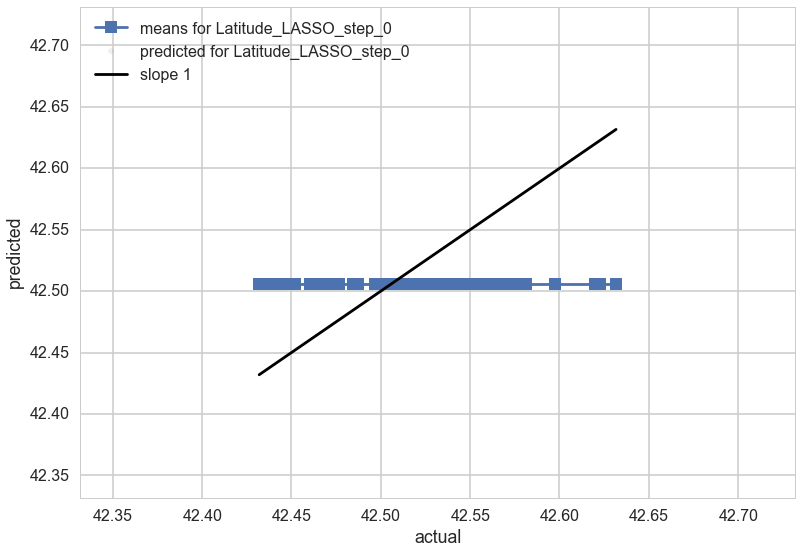

In [96]:
aimstep=0
compare_results(ytest_lat[aimstep], ytest_lat_pred[aimstep], model="Latitude_LASSO_step_0", predicteds=True);

RMSE for Latitude_LASSO_step_1 0.0368547884932


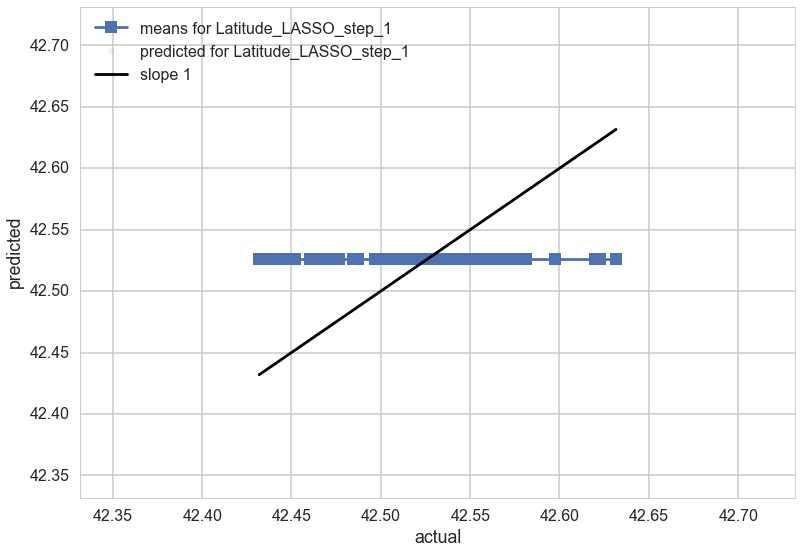

In [97]:
aimstep=1
compare_results(ytest_lat[aimstep], ytest_lat_pred[aimstep], model="Latitude_LASSO_step_1", predicteds=True);

RMSE for Longitude_LASSO_step_0 0.0957115436397


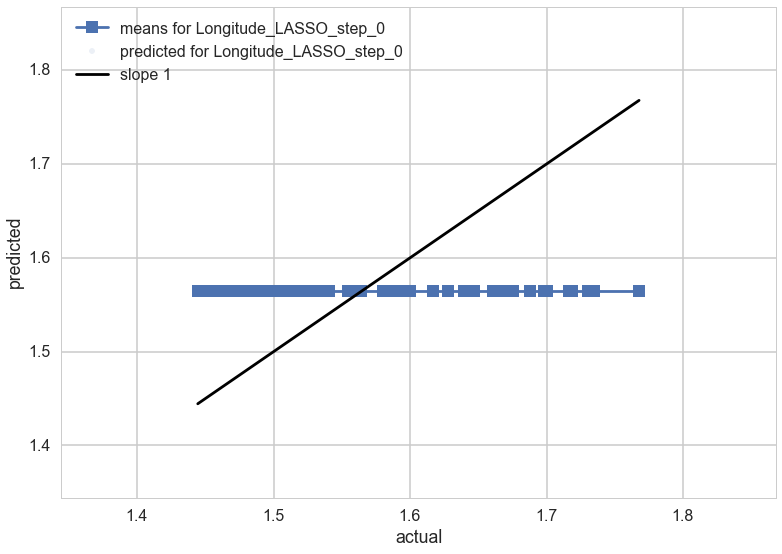

In [98]:
aimstep=0
compare_results(ytest_lon[aimstep], ytest_lon_pred[aimstep], model="Longitude_LASSO_step_0", predicteds=True);

** Comment on predicting Latitude and Longitude using full history **

Comparison between predicted value and actual value revealed that we have very small variace but relatively large bias. Although we obtained relative small RMSE, Lasso may not be ideal in predicting future latitude and longitude.

In [99]:
with open('tempdata/ML_4/ytest_lat.p', 'w') as of18:
    pickle.dump(ytest_lat, of18)
with open('tempdata/ML_4/ytest_lat_pred.p', 'w') as of19:
    pickle.dump(ytest_lat_pred, of19)
with open('tempdata/ML_4/clfLasso_lat.p', 'w') as of20:
    pickle.dump(clfLasso_lat, of20)
with open('tempdata/ML_4/rmse_lat.p', 'w') as of21:
    pickle.dump(rmse_lat, of21)
    
with open('tempdata/ML_4/ytest_lon.p', 'w') as of22:
    pickle.dump(ytest_lon, of22)
with open('tempdata/ML_4/ytest_lon_pred.p', 'w') as of23:
    pickle.dump(ytest_lon_pred, of23)
with open('tempdata/ML_4/clfLasso_lon.p', 'w') as of24:
    pickle.dump(clfLasso_lon, of24)
with open('tempdata/ML_4/rmse_lon.p', 'w') as of25:
    pickle.dump(rmse_lon, of25)

## Final Results and Conclusion

From our analysis, linear methods did not obtained optimal results. Non-linear methods, including random forest, may work better in prediction future location

Our algorithm can be used to predict the next location based on previous locations. Here are some examples:

**French**

In [170]:
clfForest_full[0].predict([-1])

array([ 6.])

The first city that a French tourist may visit is 6: CL6

In [171]:
clfForest_ct[1].predict([-1, 6])

array([ 6.])

In [172]:
clfForest_ct[2].predict([-1, 6, 6])

array([ 6.])

If a French tourist first visits city 6, he/she may keep staying in city 6.

In [173]:
clfForest_ct[1].predict([-1, 0])

array([ 0.])

In [174]:
clfForest_ct[2].predict([-1, 0, 0])

array([ 0.])

If a French tourist instead visits city 0:CL1-center, he/she may keep staying in city 0:CL1-center.

**Spanish**

In [175]:
clfForest_ct[0].predict([-2])

array([ 1.])

In [176]:
clfForest_ct[1].predict([-2, 1])

array([ 0.])

In [177]:
clfForest_ct[2].predict([-2, 1, 0])

array([ 0.])

For Spanish tourists, after visiting city 1:CL0, they tend to move to city 0:CL1-center and stay in 0:CL1-center.

### Implication for recommendation system

It seems French tourists prefer to stay in City 6. So recommending restaurants as well hotels in City 6 for French tourists may be a good idea. On the contrast, Spanish tourist tend to shortly stop by City 1 then move to and stay in City 0: center. So for Spanish tourists, only recommending restaurants may be enough for City 1. But for City 0:CL1-center, they will need hotel recommendations as well. 

## Future Directions